## Sanity checking when model behaviours should overlap

Many of the model classes in GPflow have overlapping behaviour in special cases. In this notebook, we fit some approximations to a model with a Gaussian likelihood, and make sure they're all the same. 

The models are:
 - `GPR`: Full Gaussian process regression.
 
 - `VGP`: A Gaussian approximation with Variational Bayes.
   Approximating a Gaussian posterior with a Gaussian should be exact.
   
 - `SVGP`: a sparse GP, with a Gaussian approximation. The inducing points are set to be at the data points, so again, should be exact. 
 
 - `SVGP` (with whitened representation): As above, but with a rotation applied to whiten the representation of the process.
 
 - `SGPR`: A sparse GP with a *collapsed* posterior (Titsias 2009). Again, the inducing points are fixed to the data points. 
 
 - `GPRFITC`: The FITC approximation. Again, the inducing points are fixed to the data points.
 
In all cases the parameters are estimated by the method of maximum likelihood (or approximate maximum likelihood, as appropriate). The parameter estimates should all be the same.

In [1]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

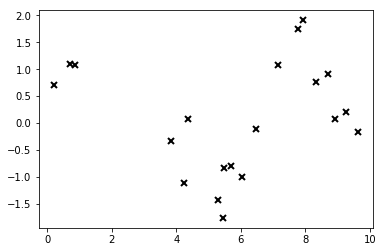

In [2]:
np.random.seed(0)
X = np.random.rand(20,1)*10
Y = np.sin(X) + 0.9 * np.cos(X*1.6) + np.random.randn(*X.shape)* 0.4
Xtest = np.random.rand(10,1)*10
plt.plot(X, Y, 'kx', mew=2);

In [3]:
m1 = gpflow.models.GPR(kernel=gpflow.kernels.RBF(1))
m2 = gpflow.models.VGP(kernel=gpflow.kernels.RBF(1),
                       likelihood=gpflow.likelihoods.Gaussian(),
                       num_data=X.shape[0])
m3 = gpflow.models.SVGP(gpflow.kernels.RBF(1),
                      likelihood=gpflow.likelihoods.Gaussian(),
                      inducing_variable=X.copy(), q_diag=False)
m3.inducing_variable.trainable = False
m4 = gpflow.models.SVGP(gpflow.kernels.RBF(1),
                      likelihood=gpflow.likelihoods.Gaussian(),
                      inducing_variable=X.copy(), q_diag=False, whiten=True)
m4.inducing_variable.trainable = False
m5 = gpflow.models.SGPR(gpflow.kernels.RBF(1), inducing_variable=X.copy())
m5.inducing_variable.trainable = False
m6 = gpflow.models.GPRFITC(gpflow.kernels.RBF(1), inducing_variable=X.copy())
m6.inducing_variable.trainable = False
models = [m1, m2, m3, m4, m5, m6]

Now, we optimize the models. For `GPR`, `SVGP` and `GPRFITC`, this simply optimizes the hyperparameters (since the inducing points are fixed). For the variational models, this jointly maximises the lower bound to the marginal likelihood (Evidence Lower Bound, ELBO) with respect to the variational parameters and the kernel and likelihood hyperparameters.

In [4]:
opt = gpflow.optimizers.Scipy()
for m in models:
    def objective_closure():
        return m.objective((X, Y))

    opt_logs = opt.minimize(objective_closure,
                            m.trainable_variables,
                            options=dict(maxiter=100))

If everything worked as planned, the models should have the same:

 - posterior distribution
 - log (marginal) likelihood
 - kernel parameters
 
For the variational models, where we use a ELBO in place of the likelihood, the ELBO should be tight to the likelihood in the cases studied here. 

(-3, 3)

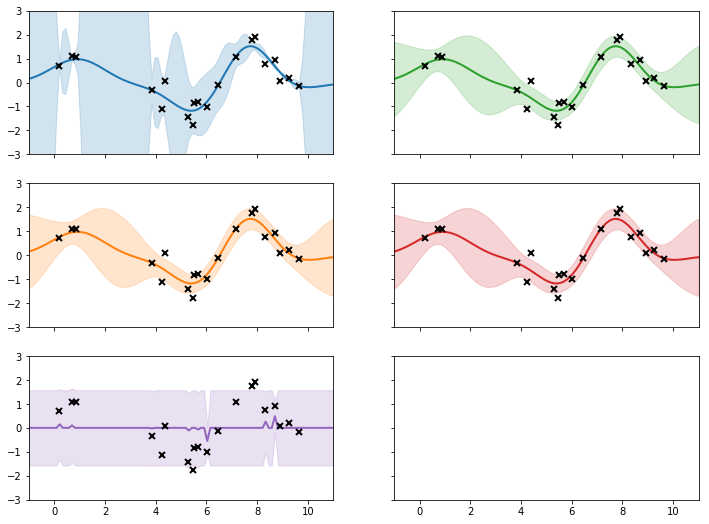

In [9]:
def plot(m, color, ax):
    xx = np.linspace(-1, 11, 100)[:, None]
    mu, var = m.get_posterior((X, Y)).predict_f(xx)
    ax.plot(xx, mu, color, lw=2)
    ax.fill_between(xx[:,0], mu[:,0] -  2*np.sqrt(var[:,0]), mu[:,0] +  2*np.sqrt(var[:,0]), color=color, alpha=0.2)
    ax.plot(X, Y, 'kx', mew=2)
    ax.set_xlim(-1, 11)

f, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12,9))
plot(m1, 'C0', ax[0,0])
plot(m2, 'C1', ax[1,0])
plot(m3, 'C2', ax[0,1])
plot(m4, 'C3', ax[1,1])
plot(m5, 'C4', ax[2,0])
#plot(m6, 'C5', ax[2,1])
plt.ylim(-3, 3)

Here are the kernels and likelihoods, which show the fitted kernel parameters and noise variance:

In [ ]:
for m in models:
    print(m.__class__.__name__)
    print("  kernel lengthscale  = {:.5g}".format(m.kernel.lengthscale.numpy()))
    print("  kernel variance     = {:.5g}".format(m.kernel.variance.numpy()))
    print("  likelihood variance = {:.5g}".format(m.likelihood.variance.numpy()))

Here are the likelihoods (or ELBOs):

In [ ]:
for m in models:
    print("{:30}  {}".format(m.__class__.__name__, m.objective((X, Y))))

In [ ]:
debug

In [ ]:
import tensorflow as tf

In [ ]:
tf.shape(np.array([1, 2, 3])).ndims


In [ ]:
tf.constant(np.array([1,2])).shape.ndims

In [ ]:
tf.constant?